In [1]:
# !pip install pytensor==2.8.11
# !pip install pymc==5.0.1

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pymc as pm
import arviz as az
import pytensor
import pytensor.tensor as pt
from sklearn.preprocessing import MinMaxScaler

print(f"Running on PyMC - v{pm.__version__}")
print(f"Running the PyTensor - v{pytensor.__version__}")

Running on PyMC - v5.0.1
Running the PyTensor - v2.8.11


In [3]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
sns.color_palette("pastel")
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
az.style.use("arviz-darkgrid")

# Bayesian Media Mix Model

- Media mix models (MMM) are used to understand how media spending affects sales and to optimize the allocation of spend across media to get the optimal media mix. These models are usually based on weekly or monthly aggregated national or geo-level data. The data may include sales, price, product distribution, media spending in different channels, and external factors such as macroeconomic forces, weather, seasonality, and market competition. The model is estimated using a Bayesian approach to make use of prior knowledge accumulated in previous or related media mix models.

In [5]:
# Loading the data

df = pd.read_csv('MMM_test_data.csv')
df.head()

,start_of_week,revenue,spend_channel_1,spend_channel_2,spend_channel_3,spend_channel_4,spend_channel_5,spend_channel_6,spend_channel_7
0,30-08-20,157906.75,2625.48,262.71,12954.12,3609.63,12955.29,12659.12,19379.79
1,06-09-20,186425.68,2634.01,108.66,8760.28,4560.60,12747.70,12338.18,22473.45
2,13-09-20,161607.39,2087.08,110.32,7155.42,4362.96,15015.41,10811.15,22596.05
3,20-09-20,180089.13,1690.70,52.79,15185.22,3883.41,15521.41,12890.22,24728.73
4,27-09-20,217793.98,1547.30,80.56,18524.05,4043.09,15793.74,12642.55,26515.48


- The data containes media spend per channel (spend_channel) and the corresponding revenue generated by all the media channels per week. Based on the date column (start_of_week), it is easier to calculate trend and seasonality. 

In [6]:
df['start_of_week'] = pd.to_datetime(df['start_of_week'], dayfirst=True)

In [7]:
# Trend
df['trend'] = (df['start_of_week'] - df['start_of_week'].min()) / (df['start_of_week'].max() - df['start_of_week'].min())

In [8]:
# Seasonality
df['day_of_year'] = df['start_of_week'].dt.day_of_year

df['sin'] = - np.sin(2 * 2 * np.pi * df['day_of_year'] / 365.25)
df['cosine'] = np.cos(1 * 2 * np.pi * df['day_of_year'] / 365.25)

df["seasonality"] = 0.25 * (df['sin'] + df['cosine'])

In [9]:
# Fourier modes to model the seasonality

n_order = 7
periods = df['day_of_year'] / 365.25
fourier_features = pd.DataFrame(
    {
        f"{func}_order_{order}": getattr(np, func)(2 * np.pi * periods * order)
        for order in range(1, n_order + 1)
        for func in ("sin", "cos")
    }
)

fourier_features.head(5)

,sin_order_1,cos_order_1,sin_order_2,cos_order_2,sin_order_3,cos_order_3,sin_order_4,cos_order_4,sin_order_5,cos_order_5,sin_order_6,cos_order_6,sin_order_7,cos_order_7
0,-0.861693,-0.507430,0.874498,-0.485029,-0.025801,0.999667,-0.848314,-0.529494,0.886721,-0.462305,-0.051584,0.998669,-0.834370,-0.551205
1,-0.916409,-0.400244,0.733574,-0.679610,0.329192,0.944263,-0.997088,-0.076262,0.468965,-0.883217,0.621687,0.783266,-0.966618,0.256222
2,-0.957852,-0.287261,0.550307,-0.834962,0.641689,0.766965,-0.918971,0.394324,-0.113720,-0.993513,0.984306,0.176471,-0.451786,0.892126
3,-0.985424,-0.170118,0.335276,-0.942120,0.871351,0.490660,-0.631740,0.775180,-0.656411,-0.754404,0.855075,-0.518505,0.365484,0.930818
4,-0.998724,-0.050511,0.100892,-0.994897,0.988531,0.151016,-0.200755,0.979641,-0.968251,-0.249981,0.298569,-0.954388,0.938089,0.346394


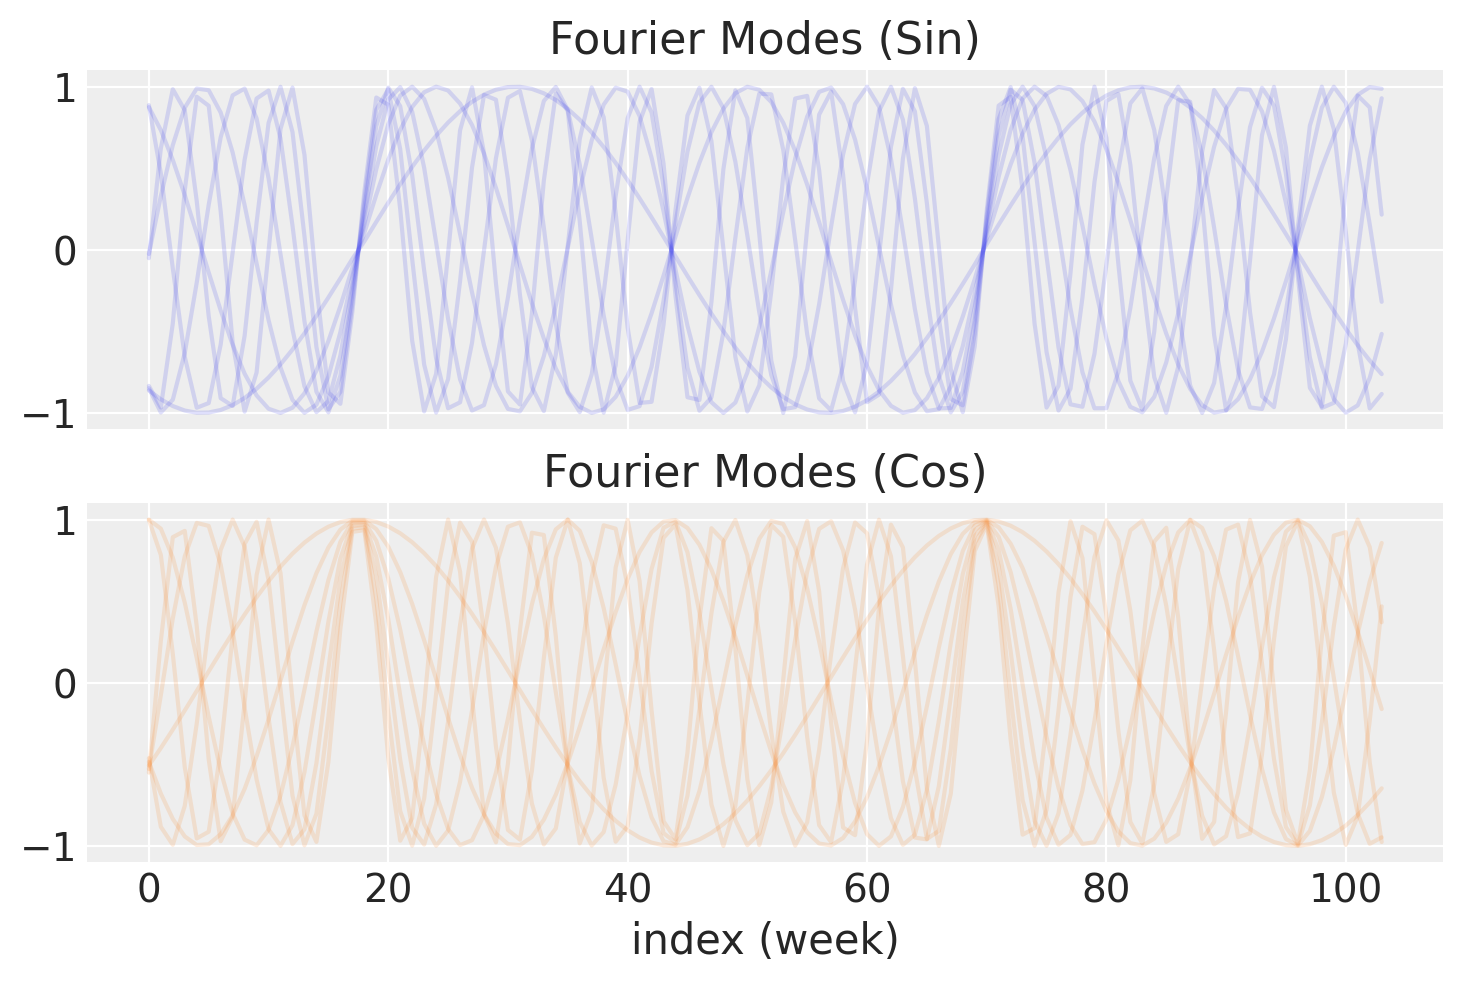

In [10]:
fig, ax = plt.subplots(nrows=2, sharex=True, layout='constrained')
fourier_features.filter(like='sin').plot(color='C0', alpha=0.15, ax=ax[0])
ax[0].get_legend().remove()
ax[0].set(title='Fourier Modes (Sin)', xlabel='index (week)')
fourier_features.filter(like='cos').plot(color="C1", alpha=0.15, ax=ax[1])
ax[1].get_legend().remove()
ax[1].set(title='Fourier Modes (Cos)', xlabel='index (week)');

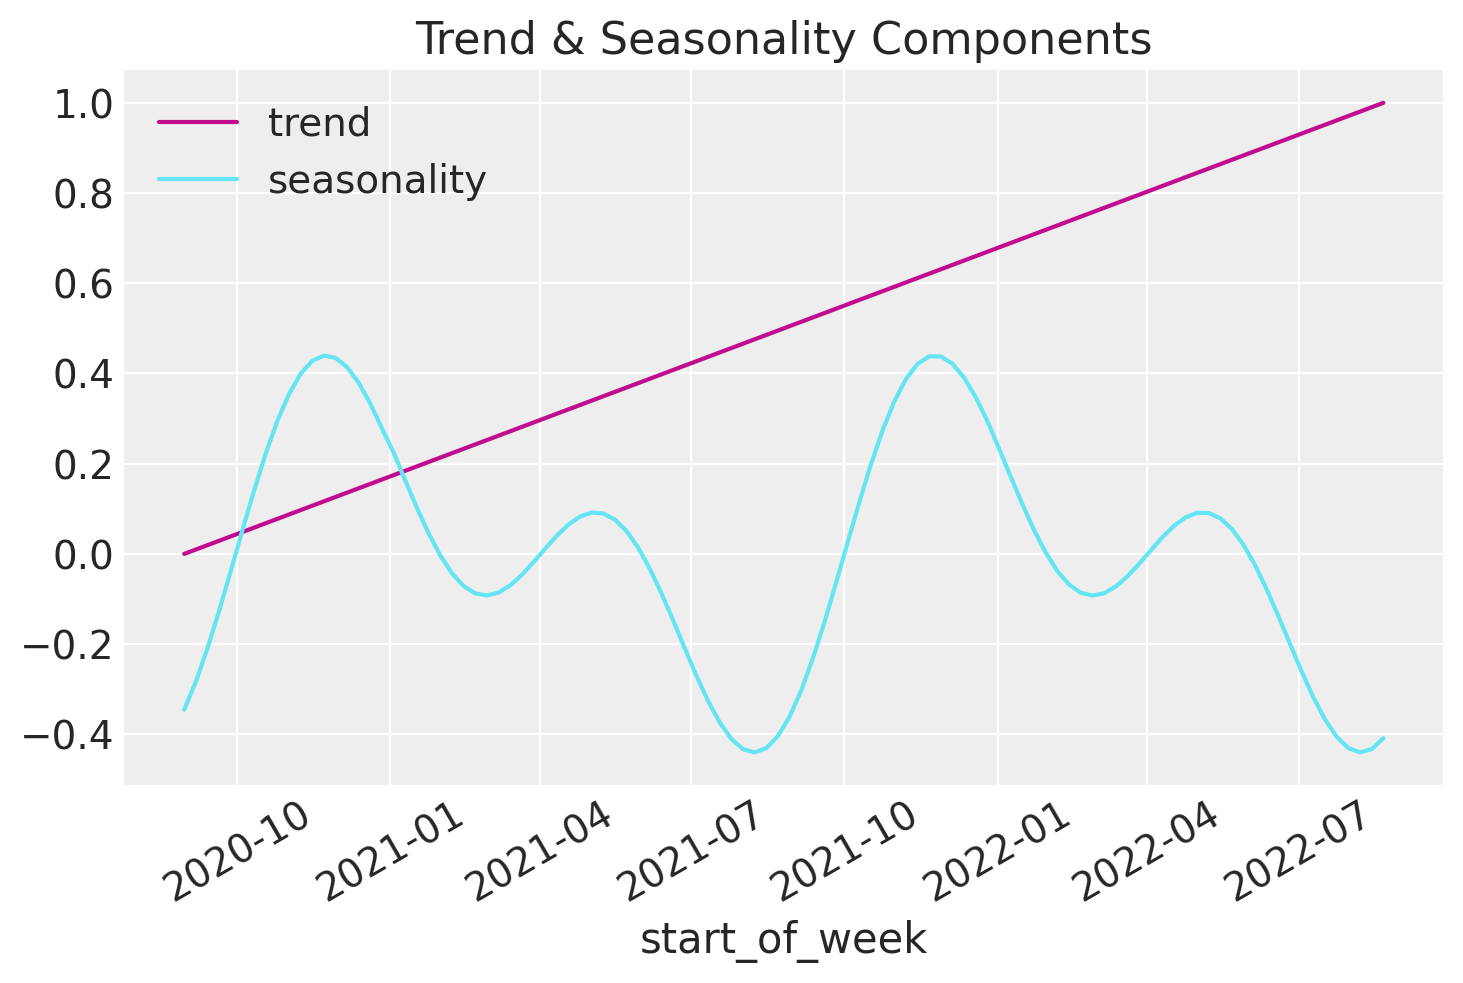

In [11]:
fig, ax = plt.subplots()
sns.lineplot(x='start_of_week', y='trend', color='C3', label='trend', data=df, ax=ax)
sns.lineplot(x='start_of_week', y='seasonality', color='C5', label='seasonality', data=df, ax=ax)
ax.legend(loc='upper left')
ax.set(title='Trend & Seasonality Components', ylabel="")
ax.tick_params(axis='x', rotation=30)

# Exploratory Data Analysis

- First of all, it is not a common practice to analyse/visualize the data first and then decide the priors of the bayesian media mixed model. However, I do not have domain expertise and much information about each media channel, therefore it is a standard practice to analyse the data first.

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104 entries, 0 to 103
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   start_of_week    104 non-null    datetime64[ns]
 1   revenue          104 non-null    float64       
 2   spend_channel_1  104 non-null    float64       
 3   spend_channel_2  104 non-null    float64       
 4   spend_channel_3  104 non-null    float64       
 5   spend_channel_4  104 non-null    float64       
 6   spend_channel_5  104 non-null    float64       
 7   spend_channel_6  104 non-null    float64       
 8   spend_channel_7  104 non-null    float64       
 9   trend            104 non-null    float64       
 10  day_of_year      104 non-null    int64         
 11  sin              104 non-null    float64       
 12  cosine           104 non-null    float64       
 13  seasonality      104 non-null    float64       
dtypes: datetime64[ns](1), float64(12), int64(1

In [13]:
df.describe()

,revenue,spend_channel_1,spend_channel_2,spend_channel_3,spend_channel_4,spend_channel_5,spend_channel_6,spend_channel_7,trend,day_of_year,sin,cosine,seasonality
count,104.000000,104.000000,104.000000,104.000000,104.000000,104.000000,104.000000,104.000000,104.000000,104.000000,104.000000,104.000000,104.000000
mean,136490.190673,1245.604808,343.640962,19507.177981,6915.136731,8575.611442,5063.699038,27701.367404,0.500000,181.519231,0.003886,0.003077,0.001741
std,50810.253012,1388.384632,332.988218,8714.759886,3123.172035,6956.787524,6689.472660,12176.293684,0.292876,106.161260,0.709114,0.711250,0.250512
min,63207.090000,0.000000,4.370000,5938.130000,3602.200000,747.460000,0.000000,9391.210000,0.000000,2.000000,-0.999745,-0.999720,-0.440005
25%,101675.685000,334.275000,120.470000,13879.000000,5113.937500,2902.032500,0.000000,19797.710000,0.250000,91.500000,-0.713528,-0.702049,-0.141108
50%,128790.460000,856.870000,202.020000,17929.450000,6194.400000,6879.270000,2423.095000,24248.640000,0.500000,181.000000,0.005368,0.003224,0.005045
75%,157707.280000,1658.032500,553.075000,22252.262500,7470.557500,14367.582500,8701.960000,33852.652500,0.750000,272.250000,0.716515,0.712784,0.145615
max,418186.380000,8513.830000,1605.850000,49689.380000,22629.690000,33009.650000,33692.830000,77488.420000,1.000000,362.000000,0.999902,0.999408,0.439733


In [14]:
df.corr()

<ipython-input-14-2f6f6606aa2c>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df.corr()


,revenue,spend_channel_1,spend_channel_2,spend_channel_3,spend_channel_4,spend_channel_5,spend_channel_6,spend_channel_7,trend,day_of_year,sin,cosine,seasonality
revenue,1.000000,0.323828,0.080848,0.381686,0.255698,0.421304,0.522644,0.249895,-0.402674,0.039392,0.231233,0.335609,0.401849
spend_channel_1,0.323828,1.000000,-0.107805,0.310750,0.306163,0.556469,0.514291,0.102148,-0.508706,0.122296,0.197071,0.133753,0.234397
spend_channel_2,0.080848,-0.107805,1.000000,0.276014,0.396803,-0.306958,-0.077497,0.588705,0.544644,-0.154438,0.087288,-0.090006,-0.002115
spend_channel_3,0.381686,0.310750,0.276014,1.000000,0.504139,0.037029,0.170534,0.496535,0.063264,0.052395,0.373090,0.141040,0.364132
spend_channel_4,0.255698,0.306163,0.396803,0.504139,1.000000,-0.182030,0.013237,0.559980,0.215112,0.175615,0.281143,0.148113,0.304085
spend_channel_5,0.421304,0.556469,-0.306958,0.037029,-0.182030,1.000000,0.650802,-0.274113,-0.742148,0.107959,0.197379,-0.115776,0.057501
spend_channel_6,0.522644,0.514291,-0.077497,0.170534,0.013237,0.650802,1.000000,0.024605,-0.634646,0.105626,0.077148,0.269320,0.245757
spend_channel_7,0.249895,0.102148,0.588705,0.496535,0.559980,-0.274113,0.024605,1.000000,0.412387,-0.094623,0.049934,0.195699,0.174243
trend,-0.402674,-0.508706,0.544644,0.063264,0.215112,-0.742148,-0.634646,0.412387,1.000000,-0.186518,-0.064812,-0.321818,-0.274291
day_of_year,0.039392,0.122296,-0.154438,0.052395,0.175615,0.107959,0.105626,-0.094623,-0.186518,1.000000,0.394765,-0.009923,0.272317


- Histogram and kdeplot are useful to identify the density distribution of the data.

In [15]:
g = sns.PairGrid(df.iloc[:, 1:])
g.map_diag(sns.histplot, kde=True)
g.map_offdiag(sns.kdeplot);

Output hidden; open in https://colab.research.google.com to view.

- It seems that the distribution of the data is quite scattered (because of the outliers). Simply removing the outliers is not a good idea in this case. Thus, I will normalize the media channels and revenue to bring them down to the same scale. Note that I am not diving further deeper into the analysis part.

# Model building & training

In [16]:
def carryover(x, alpha=0.5, theta=2, L=13, func='geometric_decay'):
    
    '''
    This carryover function transforms the input media channels into the 
    geometric decay and the delayed adstock. It takes the below parameters and 
    returns the data containing the object of the tensor operations.

    x    : spend channel data (fit_transform)
    alpha: retention rate
    theta: delay of the peak effect
    L    : maximum duration of the carryover effect
    func : either geometric_decay or delayed_adstock
    '''

    # geometric_decay
    if func == 'geometric_decay':
        w = pt.as_tensor_variable([pt.power(alpha, l) for l in range(L)])

    # delayed_adstock
    else:
        w = pt.as_tensor_variable(
                [pt.power(alpha, pt.power((l - theta), 2)) for l in range(L)]
            )
    
    # calculating the L delayed series of a single channel. 
    # cycles_shape -> (L,1)
    cycles = [pt.concatenate(
                    [pt.zeros(shape=x.shape)[:i], 
                    x[: x.shape[0] - i]]
                    ) 
                for i in range(L)
             ]
    
    # stacking them together to get a matrix. x_cycle_shape -> (L, len(x))
    x_cycle = pt.stack(cycles)
    
    output = pt.tensordot(w, x_cycle, axes=1)

    return output

In [17]:
def hill_function(x, K, S):
    
    '''
    The hill_function transforms the input media channels 
    into the shape effect. This transformation can be applied 
    before/after applying the carryover effect.

    x    : spend channel data with/without carryover effect
    K    : half saturation point
    S    : shape parameter or slope
    '''

    k_s = pt.power(K, S)
    x_s = pt.power(x, S)

    return 1 - (k_s/(x_s + k_s))

In [18]:
channel_columns = ['spend_channel_1', 'spend_channel_2', 'spend_channel_3', 'spend_channel_4', 
                   'spend_channel_5', 'spend_channel_6', 'spend_channel_7']

channel_scaler = MinMaxScaler()

df_scaled_channels = pd.DataFrame(channel_scaler.fit_transform(df[channel_columns]), columns=channel_columns)
                                  
df_scaled_channels.head(5)

,spend_channel_1,spend_channel_2,spend_channel_3,spend_channel_4,spend_channel_5,spend_channel_6,spend_channel_7
0,0.308378,0.161313,0.160361,0.000390,0.378394,0.375721,0.146681
1,0.309380,0.065121,0.064504,0.050369,0.371960,0.366196,0.192111
2,0.245140,0.066158,0.027823,0.039982,0.442250,0.320874,0.193912
3,0.198583,0.030235,0.211356,0.014779,0.457934,0.382581,0.225230
4,0.181740,0.047575,0.287670,0.023171,0.466375,0.375230,0.251468


In [19]:
y_scaler = MinMaxScaler()

y_norm = y_scaler.fit_transform(df['revenue'].values.reshape(-1, 1)).flatten()

In [20]:
L = 12

coords = {'index': df.index.values, 'fourier_mode': range(2 * n_order)}

with pm.Model(coords=coords) as test_model:
    
    # -----------------------    Priors    ------------------------
    
    # intercept
    tau = pm.Normal('intercept', mu=0, sigma=4) 
    
    # trend
    b_trend = pm.Normal(name='b_trend', mu=0, sigma=2)              
    
    # seasonality
    b_fourier = pm.Laplace(name='b_fourier', mu=0, b=2, dims='fourier_mode')
    
    # geometric adstoc
    alpha = pm.Beta('alpha', alpha=1, beta=1, shape=7)            
    
    # delayed adstock
    #theta = pm.Uniform('theta', lower=0, upper=12, shape=7)       
    theta = pm.Uniform('theta', lower=0, upper=8, shape=7)       
    
    # half-saturaion point
    k = pm.Beta('k', alpha=2, beta=2, shape=7)                
    
    # shape parameter
    s = pm.Gamma('s', alpha=3, beta=1, shape=7)
    
    # regression coefficient
    #beta = pm.HalfNormal('beta', sigma=1, shape=7)                     
    beta = pm.HalfNormal('beta', sigma=2, shape=7)                     
    
    # standard deviation of the normal likelihood
    #sigma = pm.InverseGamma('sigma', alpha=0.05, beta=0.0005)     
    sigma = pm.HalfNormal('sigma', 0.5) 

    # channel specific priors for calculating ROI
    channel_coeff = pm.HalfNormal(f'channel_coeff', sigma=1, shape=7)
    
    
    # -------------------   model parametrization     ------------------
    
    # trend
    trend = pm.Deterministic(name='trend', var=tau + b_trend * df['trend'].values, dims='index')
    
    # seasonality
    seasonality = pm.Deterministic(
        name='seasonality', var=pm.math.dot(fourier_features, b_fourier), dims='index'
    )
    
    # computing the delayed adstock followed by shape effect
    transformed_channels = []
    
    for i in range(len(channel_columns)):
        
        #i = channel_columns.index(channel)
        channel = channel_columns[i]
        
        # delayed_adstock
        adstock = carryover(df_scaled_channels[channel].values, alpha[i], theta[i], L, func='delayed_adstock')
        
        # shape effect
        adstock_saturated = beta[i] * hill_function(adstock, k[i], s[i])
        
        transformed_channels.append(adstock_saturated)
    
    # adstock_saturated
    z_adstock_saturated = pm.Deterministic(name='z_adstock_saturated', var=pm.math.sum(transformed_channels, axis=0), 
                                         dims='index') 
    
    # model parametrizations
    mu = pm.Deterministic('mu', var=trend + seasonality + z_adstock_saturated, dims='index')

    # likelihood
    y_hat = pm.Normal('y_hat', mu=mu, sigma=sigma, observed=y_norm, dims='index')

    # calculating ROI per channel
    for i in range(len(channel_columns)):
        channel = channel_coeff[i]
        ROI = pm.Deterministic(f'ROI_{channel_columns[i]}', var=(mu - channel) / channel, dims='index')

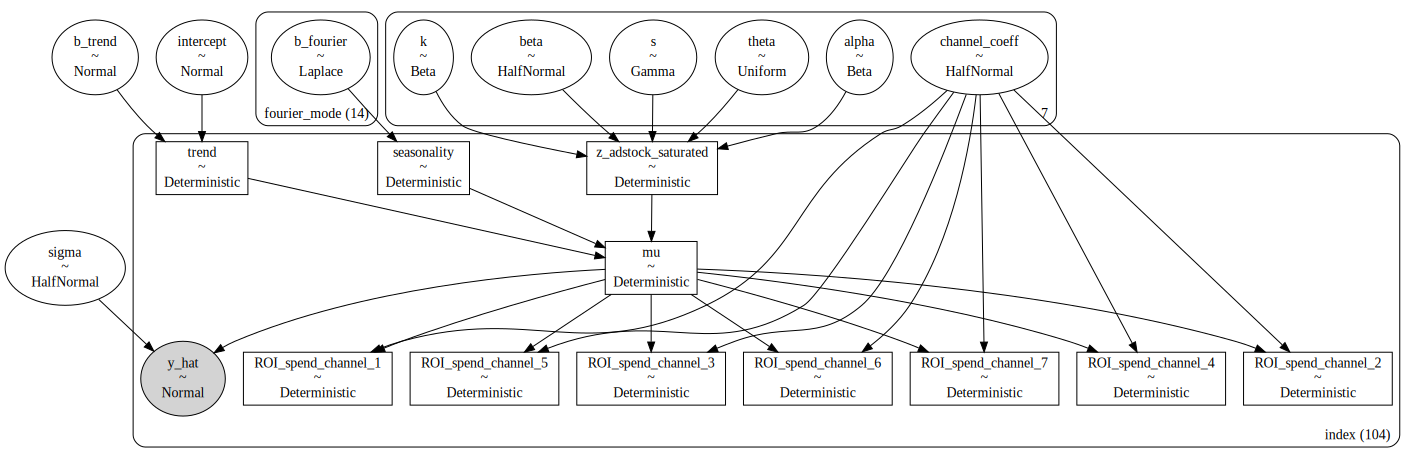

In [21]:
pm.model_to_graphviz(test_model)

In [22]:
# check model's prior predictive before seeing the actual data

with test_model:
    prior_samples = pm.sample_prior_predictive(1000, random_seed=42)

In [23]:
# calculating y_true and y_simulated_pred for comparison

y_true = y_scaler.inverse_transform(y_norm.reshape(-1, 1)).flatten()

y_simulated_pred = prior_samples.prior_predictive['y_hat'][0].mean(axis=0)
y_simulated_pred = y_scaler.inverse_transform(y_simulated_pred.values.reshape(-1, 1)).flatten()

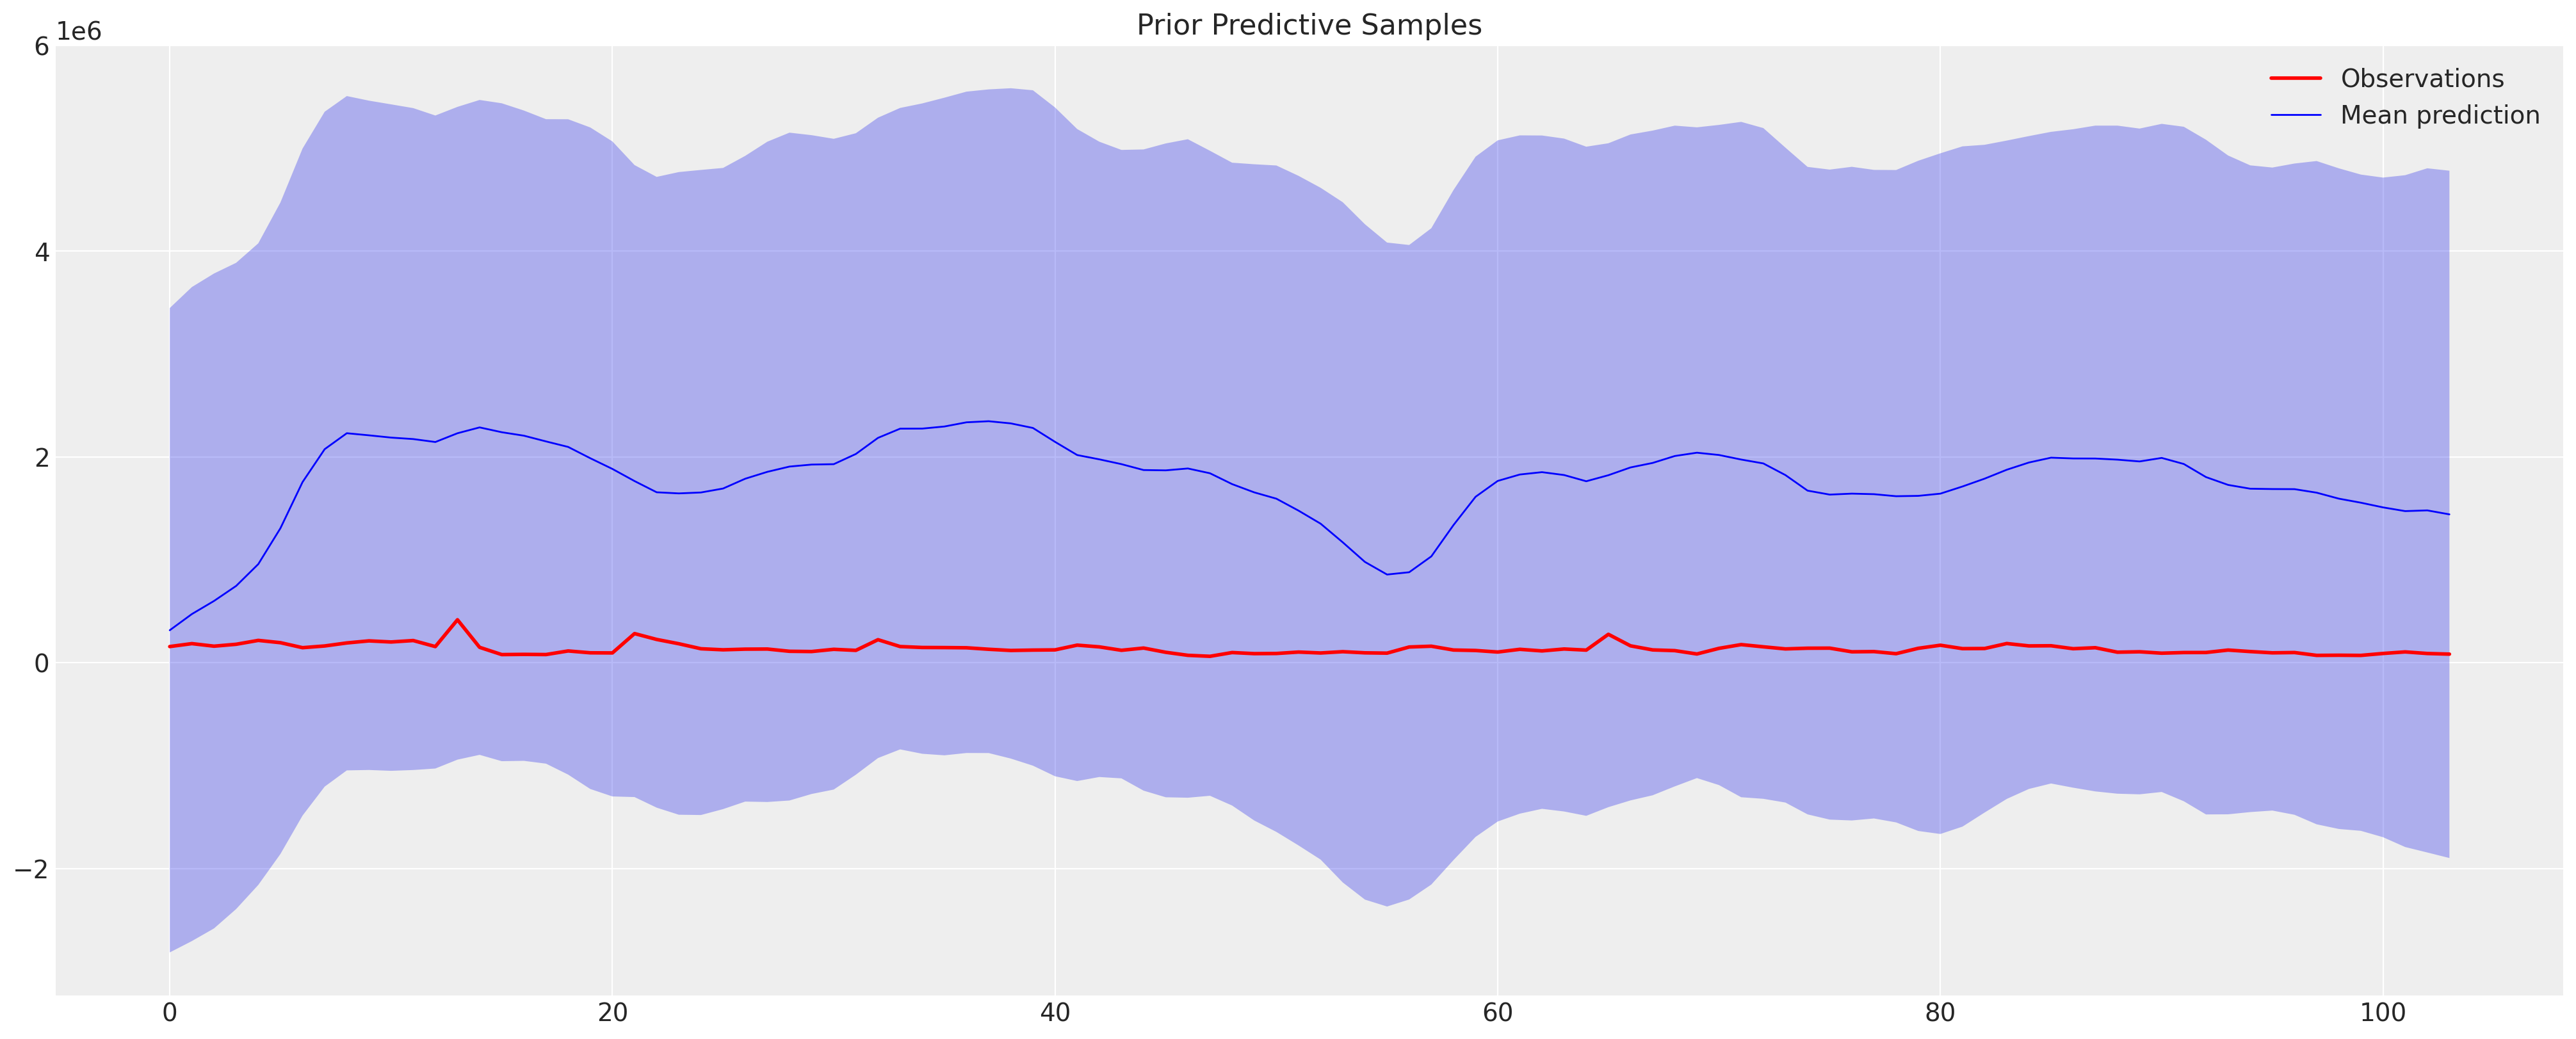

In [24]:
# Calculating mean of the prior predictive samples

std = prior_samples.prior_predictive['y_hat'][0].std(axis=0)
std = y_scaler.inverse_transform(std.values.reshape(-1, 1)).flatten()

plt.figure(figsize=(20, 8))
plt.plot(y_true, linewidth=2, c='r', label='Observations')
plt.plot(y_simulated_pred, linewidth=1, c='b', label='Mean prediction')
plt.fill_between(np.arange(len(y_true)), y_simulated_pred - std, y_simulated_pred + std, alpha=0.33)
plt.legend()
plt.title('Prior Predictive Samples');

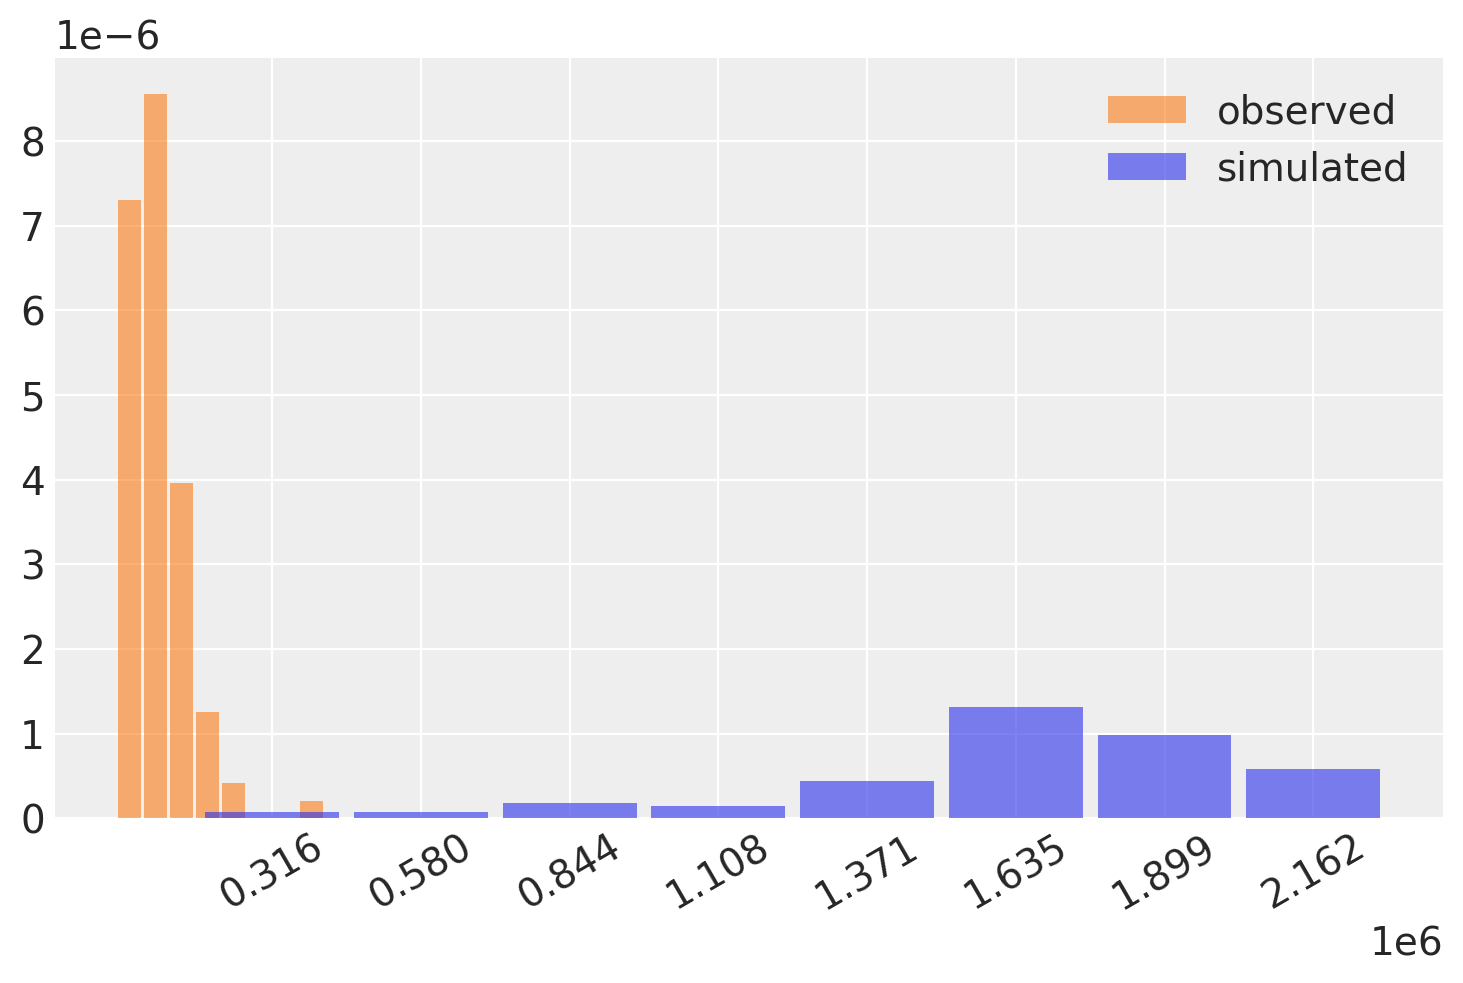

In [25]:
# Comparison of y_true and y_simulated_pred with histogram

az.plot_dist(
    y_true,
    kind='hist',
    color='C1',
    hist_kwargs=dict(alpha=0.6),
    label='observed',
)
az.plot_dist(
    y_simulated_pred,
    kind='hist',
    hist_kwargs=dict(alpha=0.6),
    label='simulated',
)
plt.xticks(rotation=30);

- Note that due to high variance in the simulated, it is a common practice to apply std on both of them in order to visualize the overlapping.

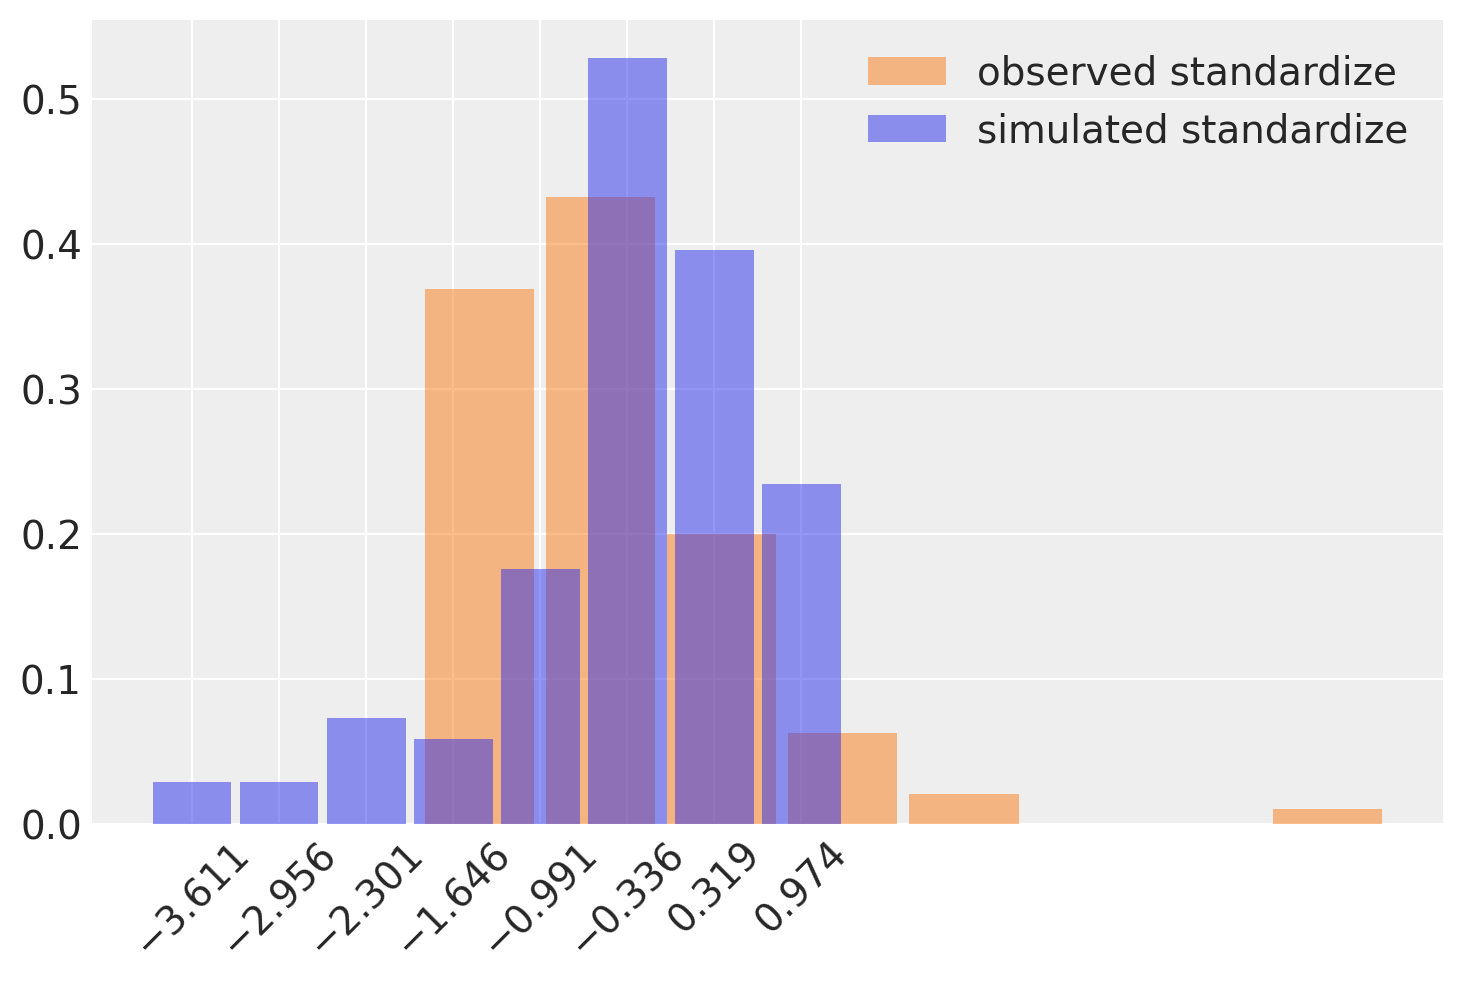

In [26]:
def standardize(series):
    return (series - series.mean()) / series.std()

az.plot_dist(
    standardize(y_true),
    kind='hist',
    color='C1',
    hist_kwargs=dict(alpha=0.5),
    label='observed standardize',
)
az.plot_dist(
    standardize(y_simulated_pred),
    kind='hist',
    hist_kwargs=dict(alpha=0.5),
    label='simulated standardize',
)
plt.xticks(rotation=45);

In [27]:
# use the actual data to train the model

with test_model:
    idata = pm.sample(1000, tune=1000, random_seed=42)

/usr/local/lib/python3.8/dist-packages/multipledispatch/dispatcher.py:27: AmbiguityWarning: 
Ambiguities exist in dispatched function _unify

The following signatures may result in ambiguous behavior:
	[ConstrainedVar, object, Mapping], [object, ConstrainedVar, Mapping]
	[ConstrainedVar, Var, Mapping], [object, ConstrainedVar, Mapping]
	[ConstrainedVar, object, Mapping], [object, ConstrainedVar, Mapping]
	[ConstrainedVar, Var, Mapping], [object, ConstrainedVar, Mapping]


Consider making the following additions:

@dispatch(ConstrainedVar, ConstrainedVar, Mapping)
def _unify(...)

@dispatch(ConstrainedVar, ConstrainedVar, Mapping)
def _unify(...)

@dispatch(ConstrainedVar, ConstrainedVar, Mapping)
def _unify(...)

@dispatch(ConstrainedVar, ConstrainedVar, Mapping)
def _unify(...)
  warn(warning_text(dispatcher.name, ambiguities), AmbiguityWarning)


# Analysis of the Model Output

In [28]:
# summary of the model

model_summary = az.summary(
    data=idata,
    var_names=['intercept', 'b_trend', 'b_fourier', 'alpha', 'theta', 'k', 's', 'beta', 'sigma']
)

model_summary

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
intercept,-0.133,0.131,-0.412,0.089,0.017,0.012,73.0,45.0,1.02
b_trend,-0.108,0.100,-0.303,0.060,0.007,0.005,206.0,258.0,1.04
b_fourier[0],-0.046,0.018,-0.081,-0.014,0.001,0.001,178.0,325.0,1.01
b_fourier[1],-0.020,0.024,-0.064,0.025,0.002,0.002,116.0,164.0,1.02
b_fourier[2],0.062,0.028,0.016,0.114,0.004,0.003,51.0,213.0,1.03
b_fourier[3],-0.033,0.019,-0.068,0.005,0.001,0.001,200.0,607.0,1.00
b_fourier[4],0.071,0.018,0.041,0.106,0.002,0.001,87.0,96.0,1.02
b_fourier[5],0.022,0.016,-0.008,0.051,0.001,0.001,171.0,528.0,1.01
b_fourier[6],-0.014,0.019,-0.049,0.020,0.002,0.001,102.0,306.0,1.02
b_fourier[7],-0.038,0.016,-0.068,-0.008,0.001,0.001,182.0,368.0,1.05


In [29]:
# checking the model behavior by visually inspecting our samples with the help of trace plot

az.plot_trace(idata, var_names=['intercept', 'b_trend', 'b_fourier', 'alpha', 'theta', 'k', 's', 'beta', 'sigma']);

Output hidden; open in https://colab.research.google.com to view.

In [30]:
# posterior distribution of each prior

az.plot_posterior(idata, var_names=['intercept', 'b_trend', 'alpha', 'theta', 'k', 's', 'beta', 'sigma']);

Output hidden; open in https://colab.research.google.com to view.

In [31]:
# posterior distribution of z_adstock_saturated

az.plot_posterior(idata, var_names=['z_adstock_saturated']);

Output hidden; open in https://colab.research.google.com to view.

- You can see the carryover delay and peak effect of all the spending of the channels from the start of the week to the 40th week.

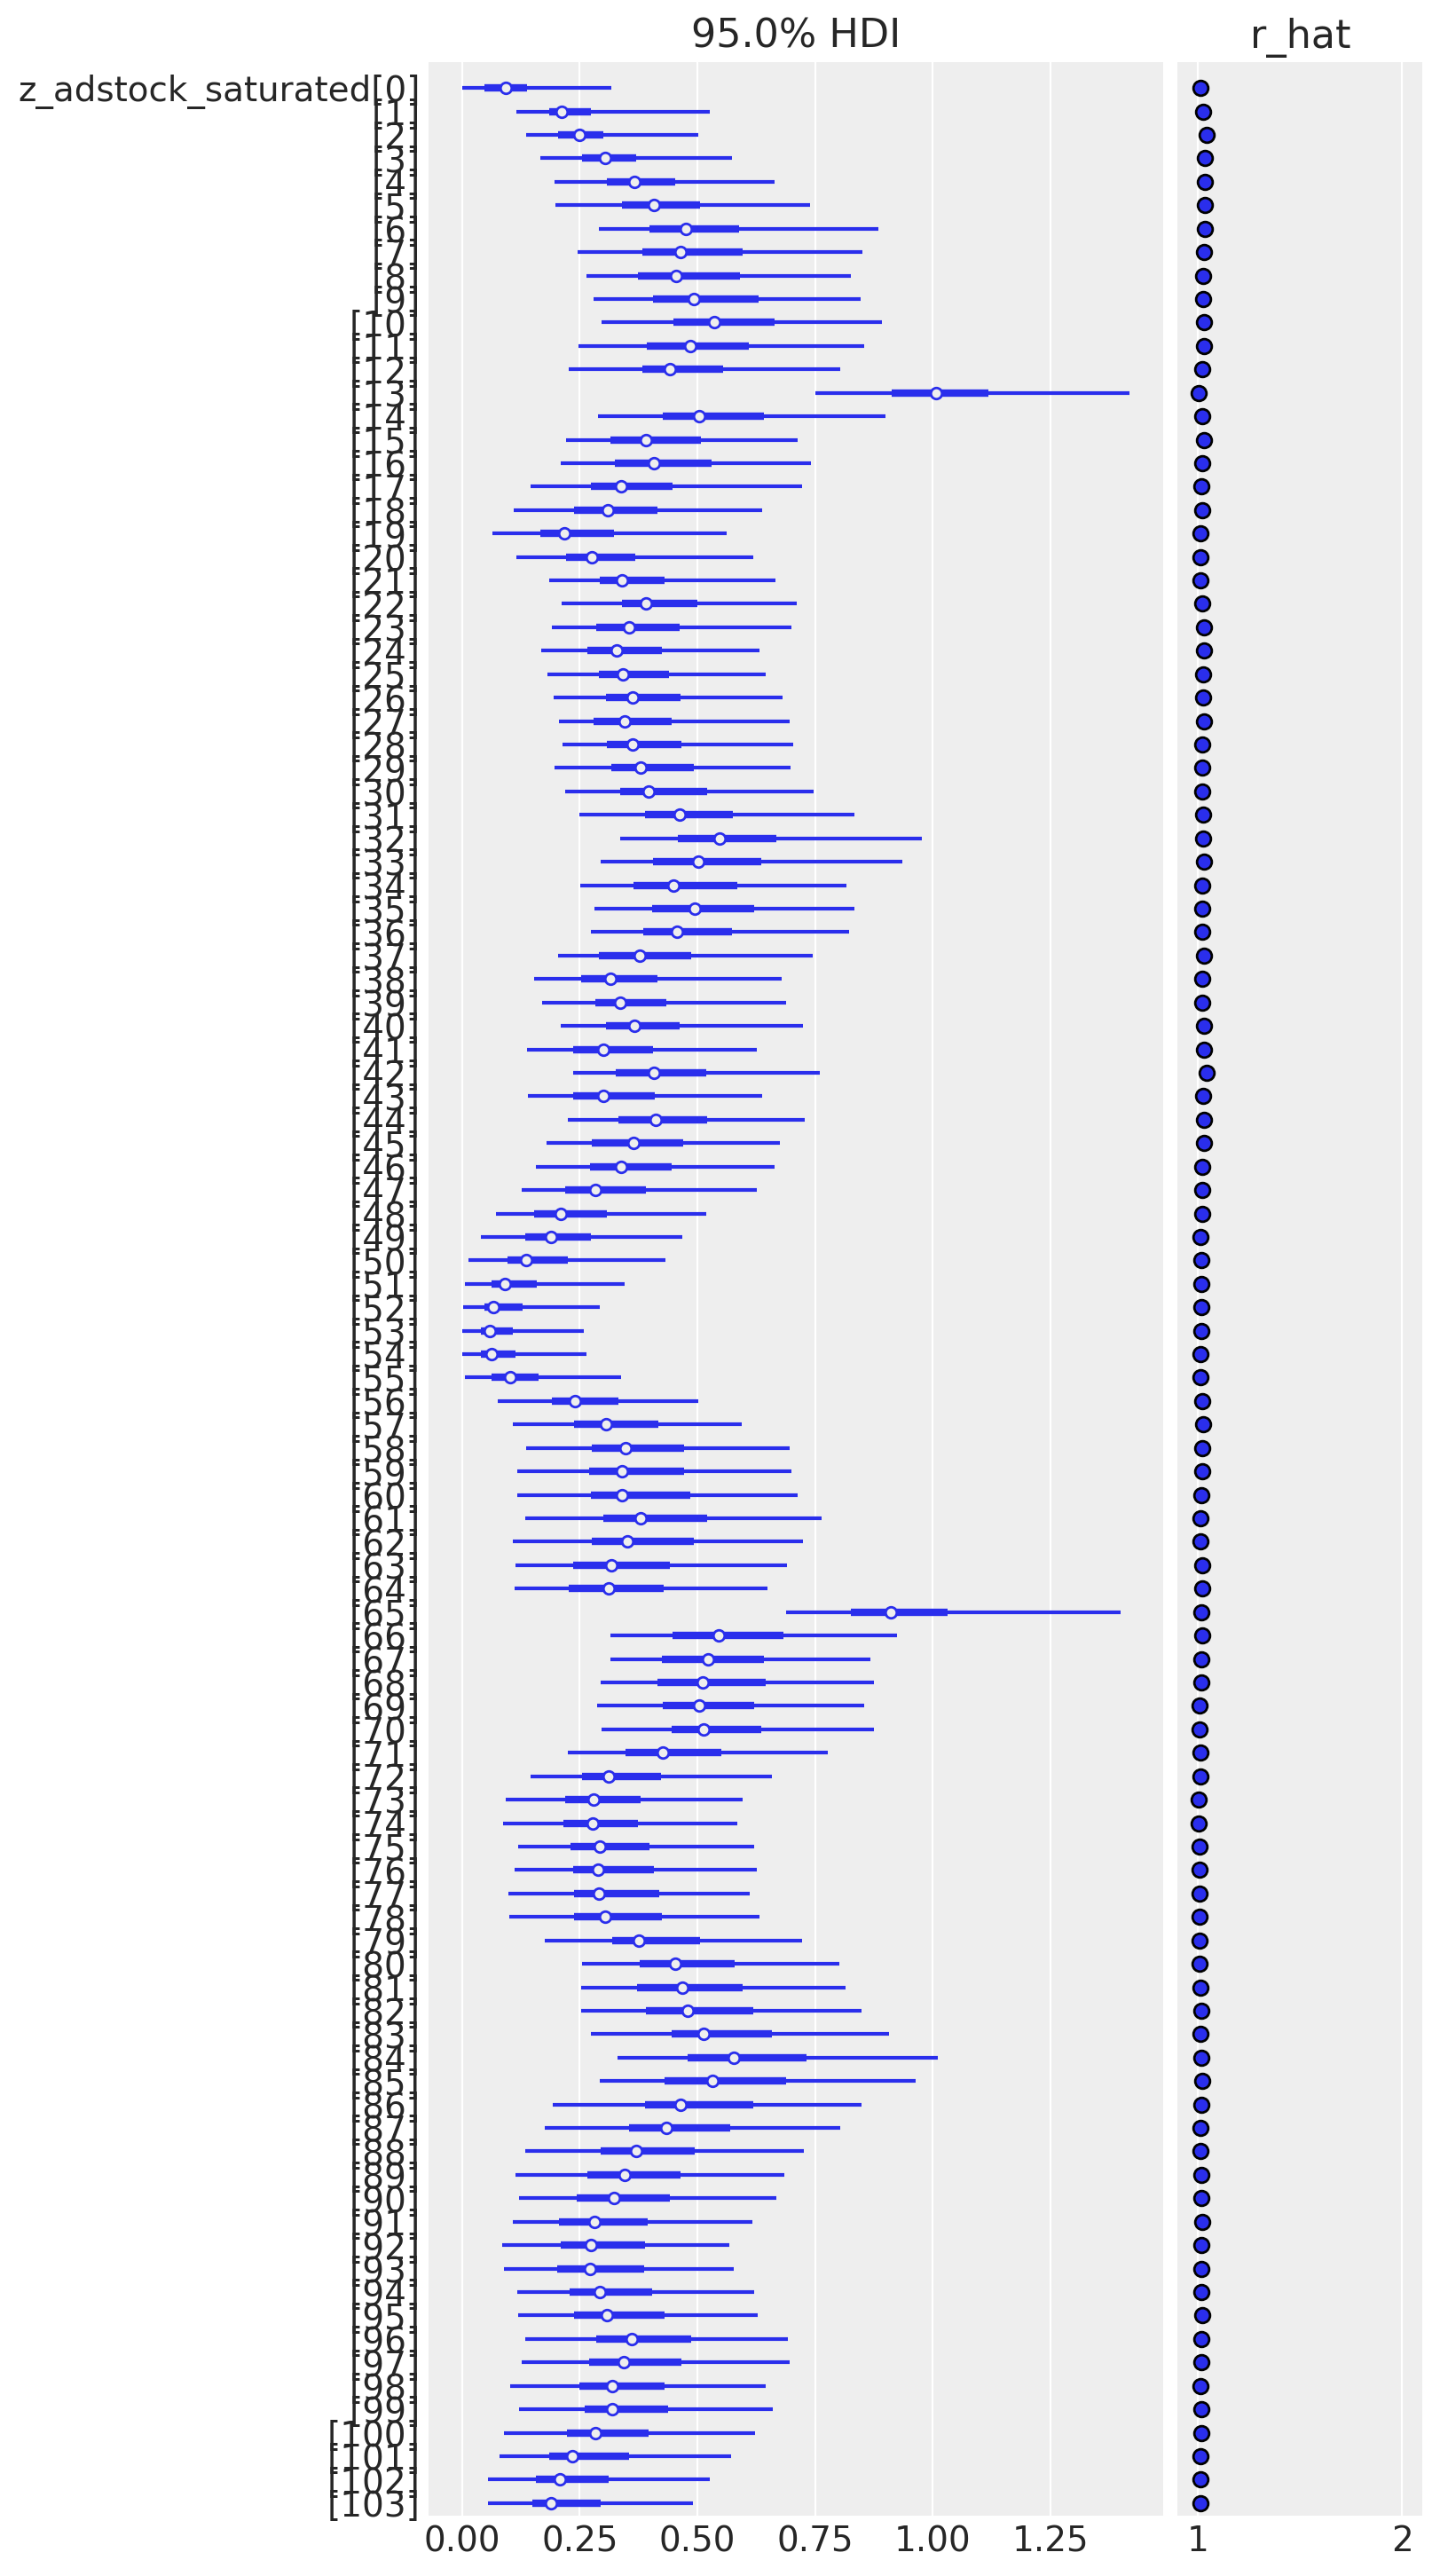

In [32]:
# estimaing the beta (regression coefficient) using plot forest

az.plot_forest(idata, var_names=['z_adstock_saturated'], combined=True, hdi_prob=0.95, r_hat=True);

- Based on the model's performance, the top 2 highest revenue were generated at the end of November 2020 and 2021. Therefore, the revenue of the next year may be estimated very well by the model.

In [33]:
# posterior predictive samples

with test_model:
    posterior = pm.sample_posterior_predictive(idata, random_seed=40)

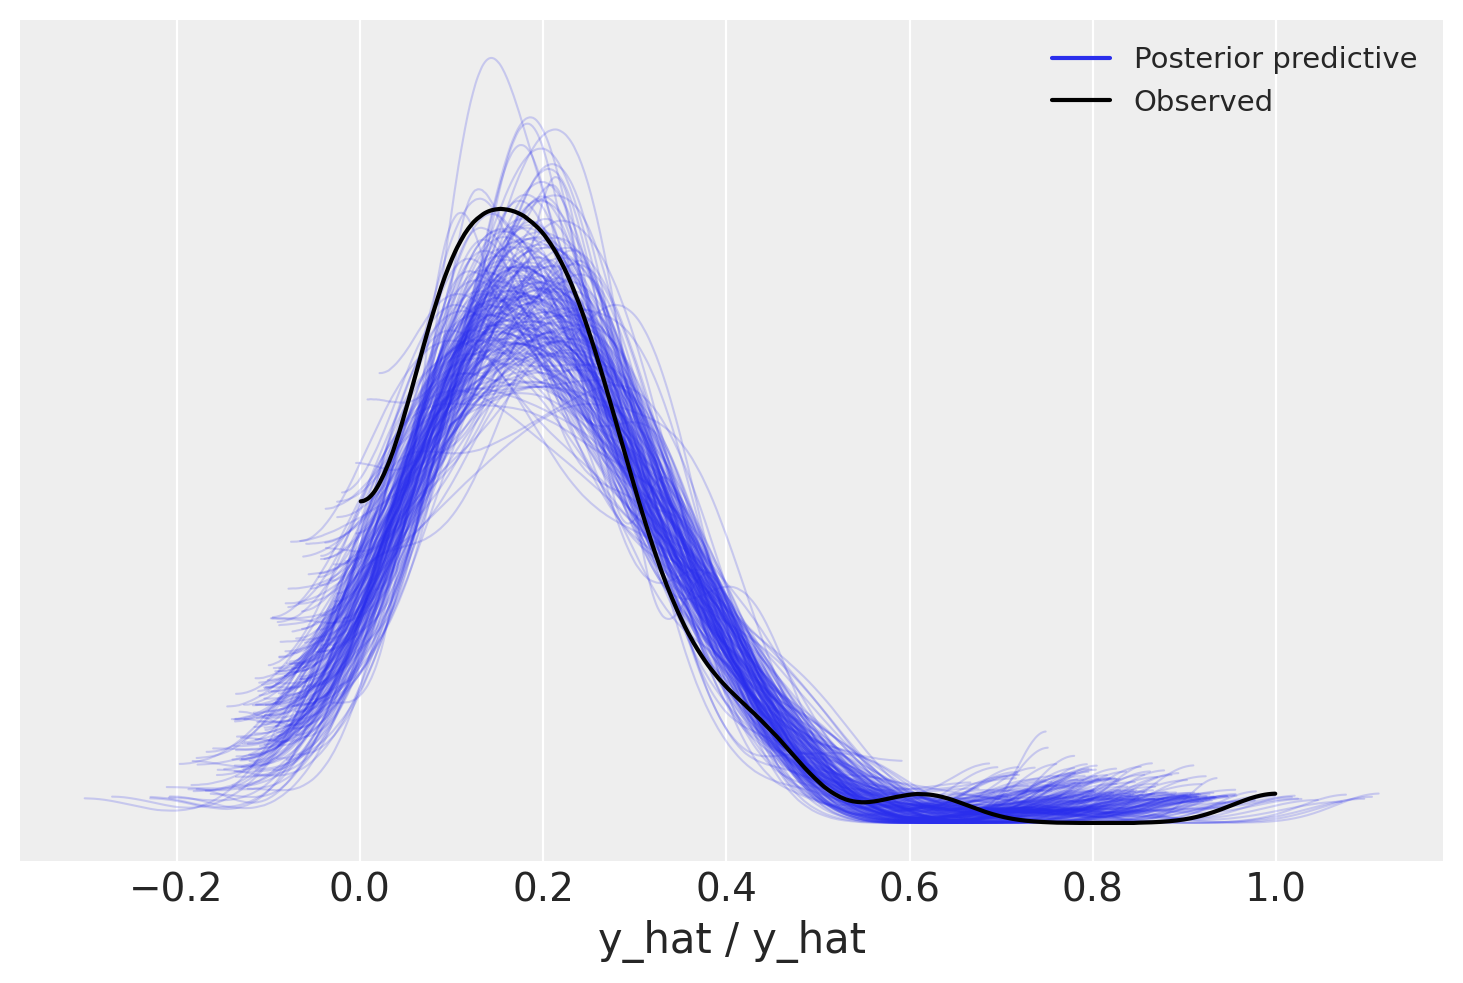

In [34]:
# posterior predicting check

pm.plot_ppc(posterior, num_pp_samples=200, mean=False, group= 'posterior');

- Based on the above PPC plot, one can visually say that the model has estimated the posterior predictive samples very well.

In [35]:
# calculating y_pred for comparison with y_true 

y_pred = posterior.posterior_predictive['y_hat'].mean(axis=0).mean(axis=0)
y_pred = y_scaler.inverse_transform(y_pred.values.reshape(-1, 1)).flatten()

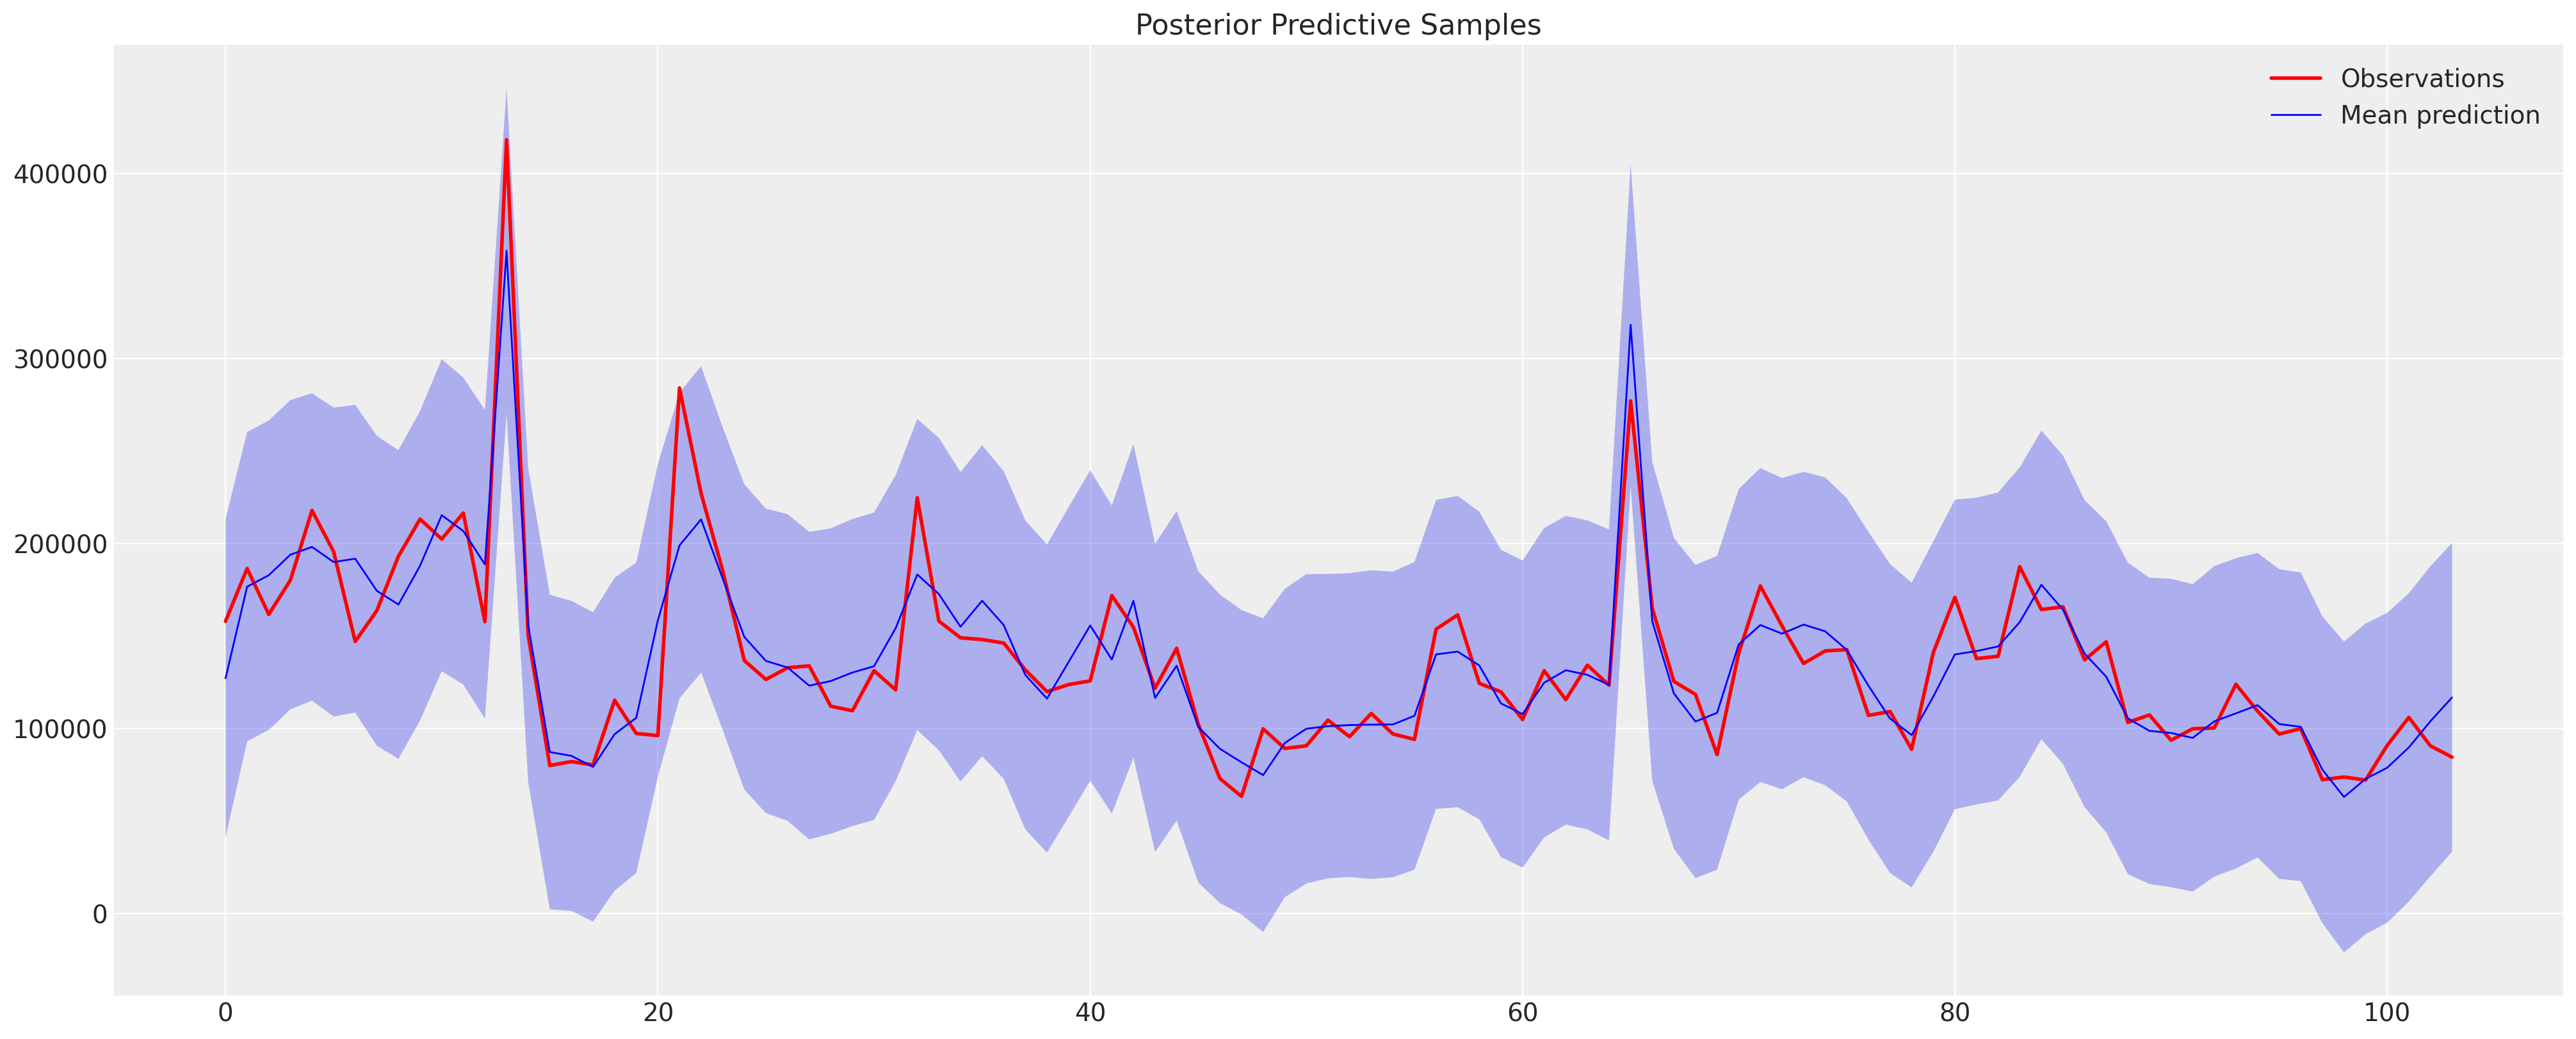

In [36]:
# Taking mean of the posterior predictive samples of all chains

std = posterior.posterior_predictive['y_hat'].mean(axis=0).std(axis=0)
std = y_scaler.inverse_transform(std.values.reshape(-1, 1)).flatten()

plt.figure(figsize=(20, 8))
plt.plot(y_true, linewidth=2, c='r', label='Observations')
plt.plot(y_pred, linewidth=1, c='b', label='Mean prediction')
plt.fill_between(np.arange(len(y_true)), y_pred - std, y_pred + std, alpha=0.33)
plt.legend()
plt.title('Posterior Predictive Samples');

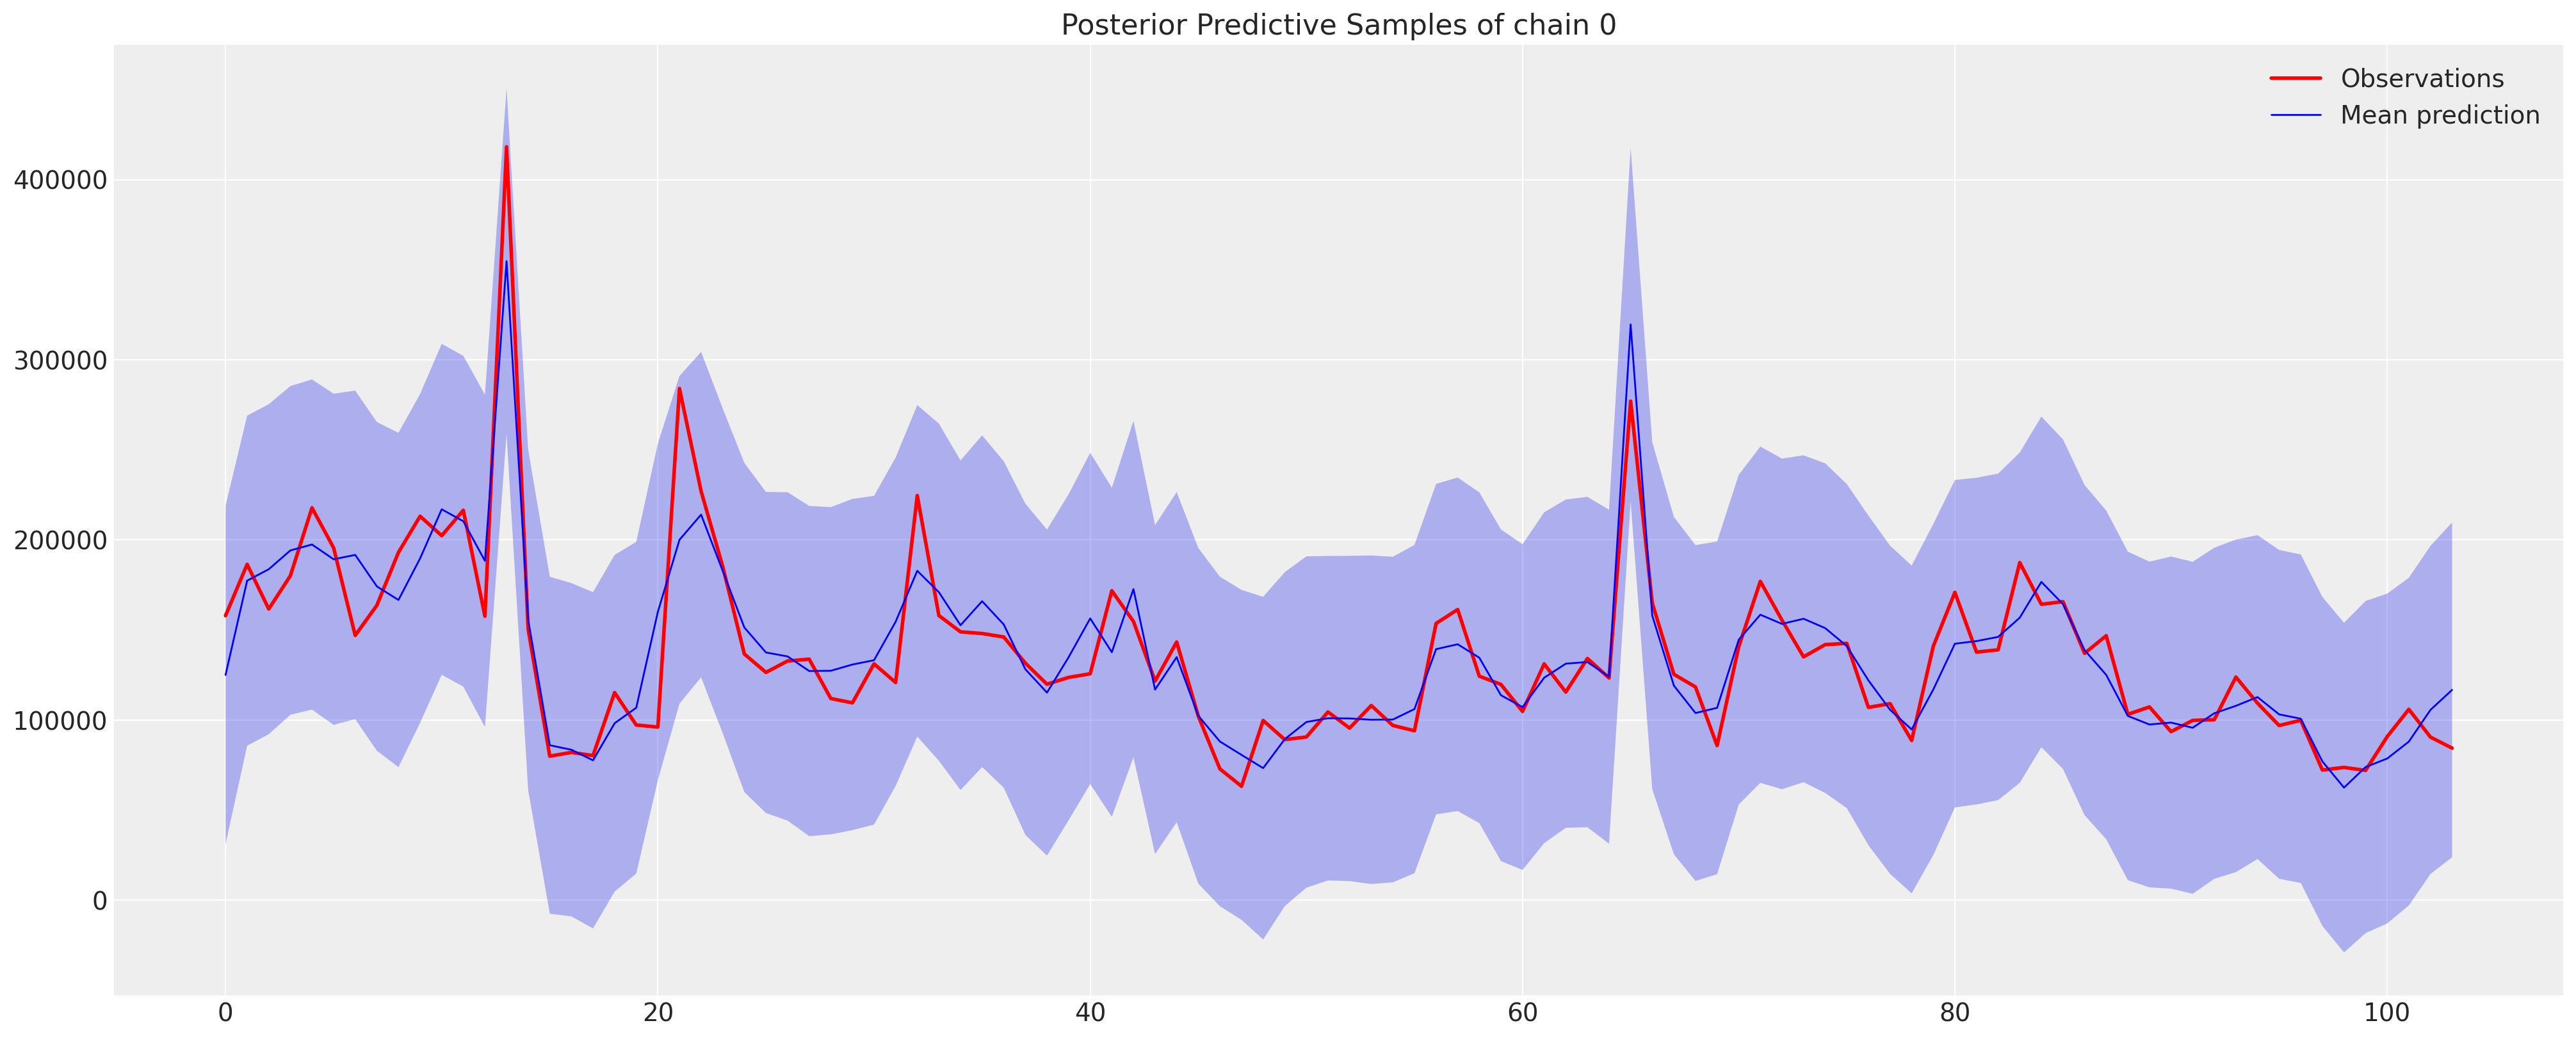

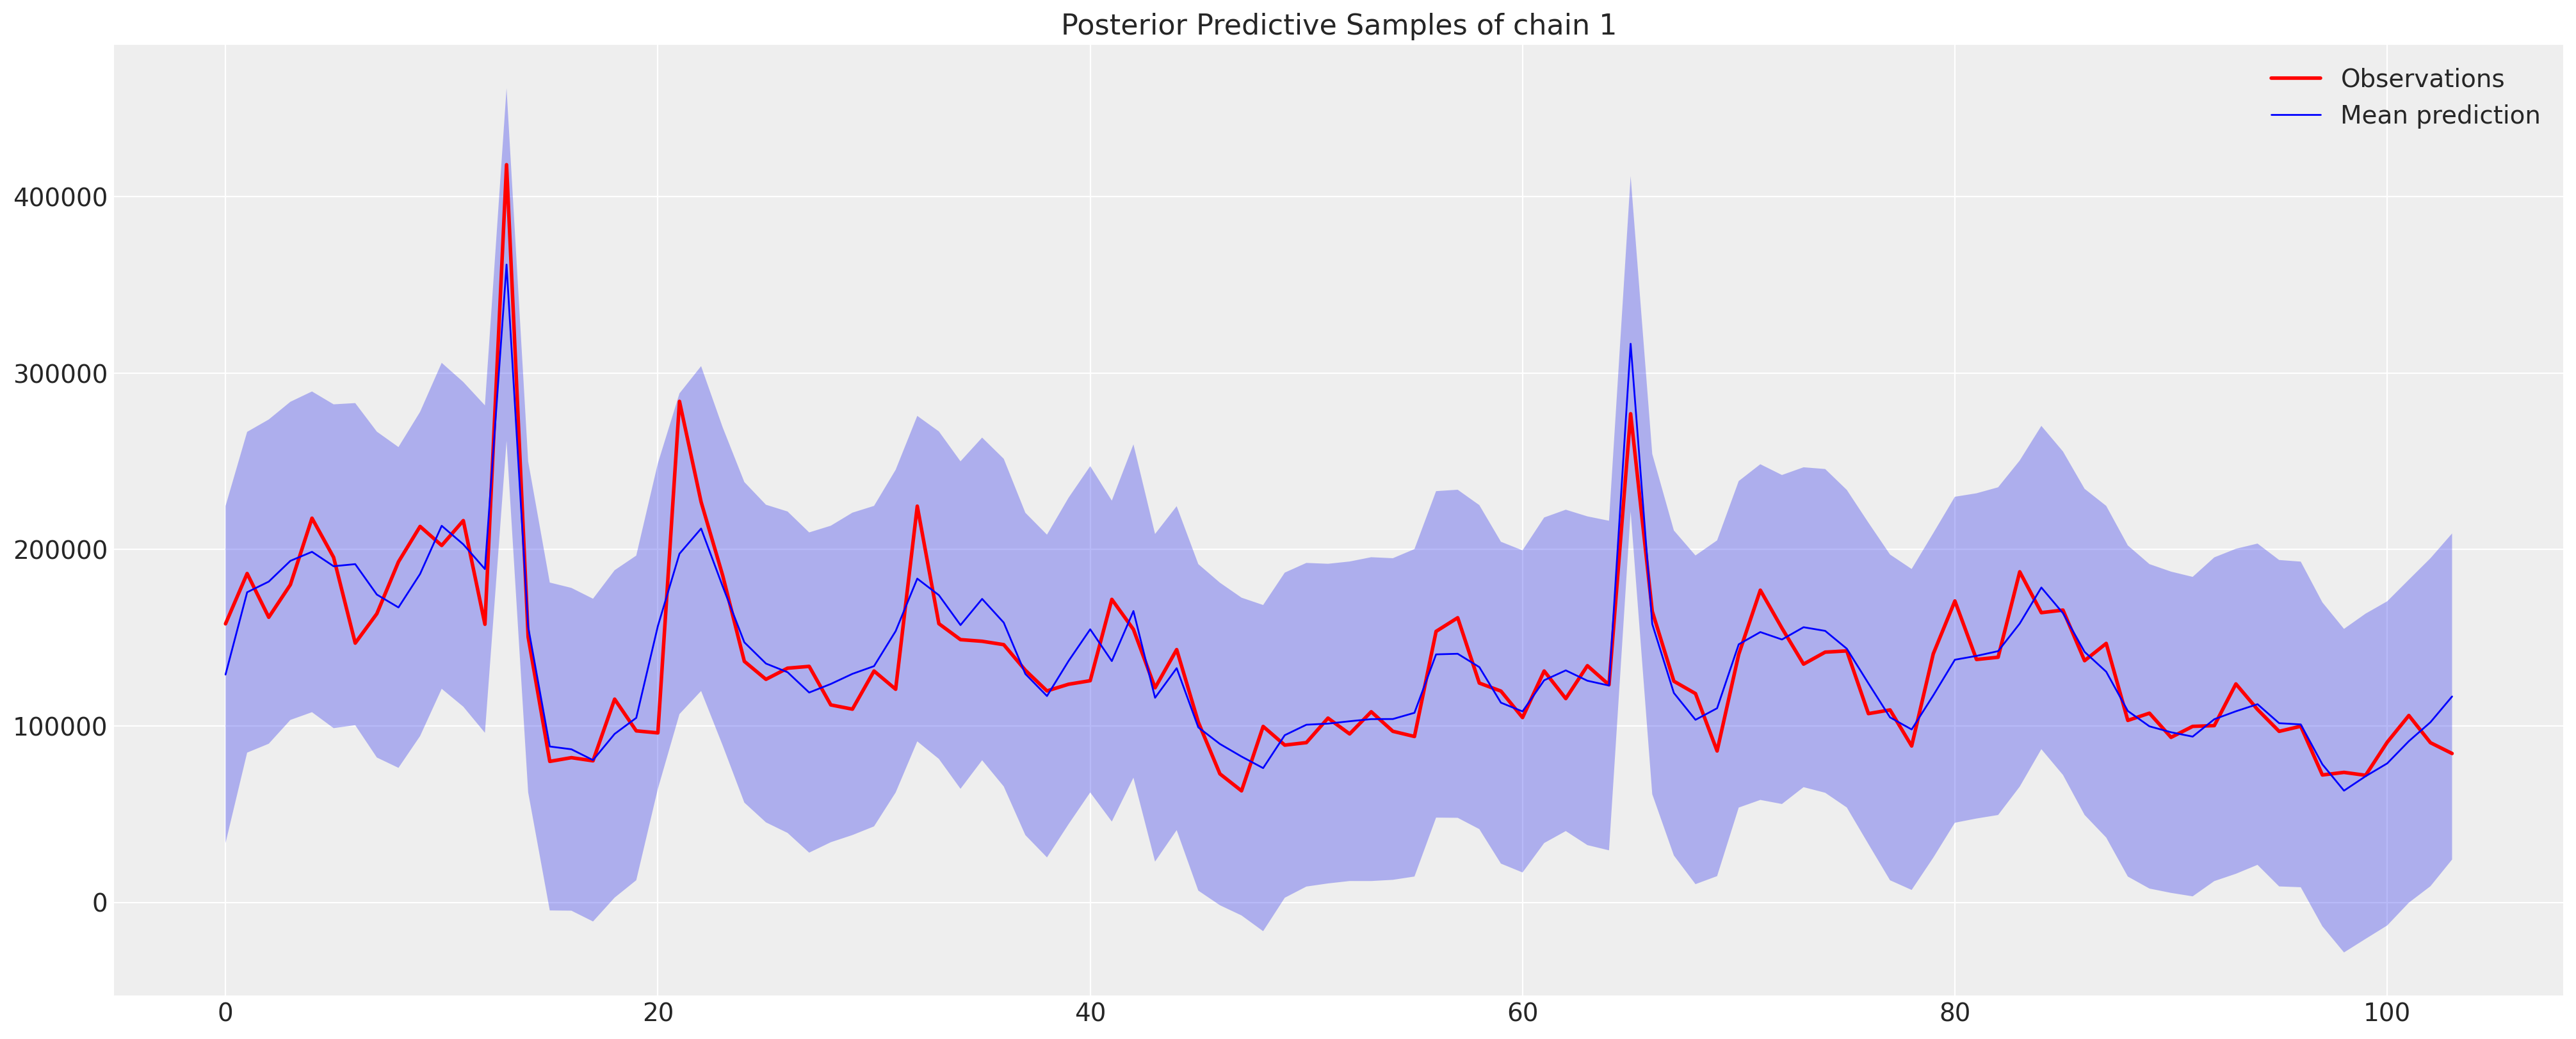

In [37]:
# Posterior predictive samples of the indivisual chain

n_chains = posterior.posterior_predictive.chain.values

for i in n_chains:

    means = posterior.posterior_predictive['y_hat'][i].mean(axis=0)
    stds = posterior.posterior_predictive['y_hat'][i].std(axis=0)
    
    means = y_scaler.inverse_transform(means.values.reshape(-1, 1)).flatten()
    stds = y_scaler.inverse_transform(stds.values.reshape(-1, 1)).flatten()
    
    plt.figure(figsize=(20, 8))
    plt.plot(y_true, linewidth=2, c='r', label='Observations')
    plt.plot(means, linewidth=1, c='b', label='Mean prediction')
    plt.fill_between(np.arange(len(y_true)), means - stds, means + stds, alpha=0.33)
    plt.legend()
    plt.title(f'Posterior Predictive Samples of chain {i}');

In [38]:
# Measuring the performance of the model using
# Mean Absolute Error (MAE)
# Mean Absolute Percentage Error (MAPE)
# Mean Square Error (MSE)
# Root Mean Square Error (RMSE)
# Normalized RMSE (NRMSE)

def calculate_score(y_true, y_pred):
    
    score = {
        'MAE': np.mean(np.abs(y_true - y_pred)),
        'MAPE': np.mean(np.abs((y_true - y_pred) / y_true)),
        'MSE': np.mean((y_true - y_pred)**2),
        'RMSE': np.sqrt(np.mean((y_true - y_pred)**2)),
        'NRMSE': np.sqrt(np.mean((y_true - y_pred)**2)) / (np.max(y_true) - np.min(y_true))
    }
    
    return score

In [39]:
# calculating the scores of prior predictive samples

calculate_score(y_true, y_simulated_pred)

{'MAE': 1633762.4619964112,
 'MAPE': 13.384966622516812,
 'MSE': 2831554844663.796,
 'RMSE': 1682722.4502762766,
 'NRMSE': 4.740339782290614}

In [40]:
# calculating the scores of posterior predictive samples

calculate_score(y_true, y_pred)

{'MAE': 14216.16712930728,
 'MAPE': 0.10352835761758747,
 'MSE': 395636741.42759854,
 'RMSE': 19890.619432978918,
 'NRMSE': 0.05603318276110959}

- Based on the above metrices, the posterior predictive samples derived from the posterior distribution perform better than the prior predictive samples.

# Return on Investment (ROI) per channel

In [76]:
roi_df = pd.DataFrame(columns=channel_columns)

for channel in channel_columns:
    roi_df[channel] = idata.posterior.get(f'ROI_{channel}').values.mean(axis=(0, 1))

roi_df

,spend_channel_1,spend_channel_2,spend_channel_3,spend_channel_4,spend_channel_5,spend_channel_6,spend_channel_7
0,-0.010599,0.157611,-0.183517,-0.407185,0.369192,-0.336654,4.160227
1,0.943172,1.097888,0.466587,0.089715,1.475017,0.239233,7.254507
2,1.115226,1.276319,0.552507,0.160466,1.623401,0.314077,6.992182
3,1.329991,1.447380,0.676498,0.261492,1.829040,0.424550,8.369513
4,1.351841,1.486611,0.740601,0.292600,1.906083,0.454457,8.889785
...,...,...,...,...,...,...,...
99,-0.766988,-0.849859,-0.871308,-0.913014,-0.542979,-0.900949,-0.265913
100,-0.705494,-0.769612,-0.785414,-0.852083,-0.550592,-0.848546,0.570222
101,-0.530764,-0.542382,-0.657001,-0.749408,-0.363962,-0.724819,1.391536
102,-0.131673,-0.258938,-0.509722,-0.615914,-0.210971,-0.540646,2.039501


In [77]:
roi_df = channel_scaler.inverse_transform(roi_df.values)
roi_df = pd.DataFrame(roi_df, columns=channel_columns)
roi_df

,spend_channel_1,spend_channel_2,spend_channel_3,spend_channel_4,spend_channel_5,spend_channel_6,spend_channel_7
0,-90.234630,256.781156,-2090.951561,-4145.504912,12658.411363,-11342.830847,292691.041489
1,8030.001896,1762.615529,26351.894609,5309.247130,48334.739860,8060.439182,503402.871483
2,9494.842582,2048.370097,30110.986281,6655.473819,53121.915563,10582.153992,485539.269451
3,11323.313219,2322.320519,35535.771599,8577.730706,59756.292911,14304.298046,579331.715046
4,11509.348691,2385.148534,38340.335663,9169.651001,62241.866807,15311.944403,614760.744889
...,...,...,...,...,...,...,...
99,-6530.003172,-1356.662697,-32182.704243,-13770.156995,-16770.240646,-30355.522102,-8716.693477
100,-6006.457234,-1228.148356,-28424.727221,-12610.793775,-17015.848633,-28589.922526,48221.710669
101,-4518.838161,-864.243126,-22806.463610,-10657.155651,-10994.762276,-24421.214467,104150.943873
102,-1121.038021,-410.314489,-16362.850437,-8117.094009,-6058.922416,-18215.900115,148275.521792


- Theoretically, the spending on a channel should be positive, however, we are getting negative values. The reason could be a deterministic function of the priors. Here, I am simply converting the negative values to zeros and calculating the last year of ROI per channel.

In [78]:
roi_df = roi_df[-52:].copy()
roi_df[roi_df < 0] = 0

roi_df

,spend_channel_1,spend_channel_2,spend_channel_3,spend_channel_4,spend_channel_5,spend_channel_6,spend_channel_7
52,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.558407e+04
53,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.159566e+04
54,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.221296e+04
55,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.194940e+05
56,3525.690483,786.186971,3807.289371,0.000000,21862.734385,0.000000,3.046605e+05
57,3089.919756,850.102009,4405.637399,0.000000,19890.208580,0.000000,3.076055e+05
58,2334.985859,564.246610,1879.048959,0.000000,19901.707146,0.000000,2.545412e+05
59,0.000000,0.000000,0.000000,0.000000,3182.059174,0.000000,1.641785e+05
60,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.581036e+05
61,473.628522,79.899166,0.000000,0.000000,9912.318483,0.000000,2.668428e+05


In [79]:
# ROI per channel

ROI_per_channel = {}

tmp_y_pred = y_pred[-52:].sum()

for channel in roi_df.columns:

    ROI_per_channel[channel] = (tmp_y_pred - roi_df[channel].sum()) / roi_df[channel].sum()

ROI_per_channel

{'spend_channel_1': 49.19385545908803,
 'spend_channel_2': 260.7900924880236,
 'spend_channel_3': 22.01953665513706,
 'spend_channel_4': 126.32769390460692,
 'spend_channel_5': 7.732971962511889,
 'spend_channel_6': 90.47635954664054,
 'spend_channel_7': -0.44247940397616814}

- Based on the ROI score, spend_channel_2 gives the highest ROI compared to the other media channels. Spending 1€ on this channel returns 260.79€ per year. On the other side, the spend_channel_7 gives the sign of diminishing return, therefore, it is advisable to reduce the spending on this media channel.